# 인재양성 실무교육프로그램: BERT Fine-Tuning Tutorial with PyTorch

Primary TA: 이영준

Mobile: +82-10-5039-2961

TA's E-mail: passing2961@gmail.com, yj2961@kaist.ac.kr

Lab Homepage: https://keai.kaist.ac.kr/

본 실습에서는 `huggingface` PyTorch 라이브러리를 이용하여 sentiment classification에서 BERT 를 어떻게 fine-tuning 하는지에 대한 부분을 설명합니다. 또한, BERT 모델을 fine-tuning 하기 위해 amazon review 데이터를 사용합니다. 

## Introduction

<center><img src="https://github.com/passing2961/KEMC/blob/master/cv.png?raw=true" width="80%" height="80%" title="cv" alt="cv"></img></center>

[VGGNet]: https://arxiv.org/pdf/1409.1556
[GoogLeNet]: https://arxiv.org/pdf/1409.4842
[ResNet]: https://arxiv.org/abs/1512.03385

[word2vec]: https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
[GloVe]: https://www.aclweb.org/anthology/D14-1162
[fastText]: https://arxiv.org/abs/1607.04606

[Semi-Supervised Sequence Learning]: https://arxiv.org/abs/1511.01432
[ELMo]: https://arxiv.org/abs/1802.05365
[OpenAI GPT]: https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf

Computer vision (CV) 분야에서는 [VGGNet], [GoogLeNet], [ResNet] 과 같은 pre-train 된 모델을 이용하여 다른 downstream task 에 적용하는 transfer learning 이 활발히 이루어지고 있습니다. Natural Language Processing (NLP) 분야에서도 [word2vec], [GloVe], [fastText] 와 같은 pre-trained word embedding 이 다른 downstream task 에 사용되어왔습니다. 그러나, 기존에 word embedding 연구들은 contextual language representation 의 표현이 어려웠습니다. 이를 해결하기 위해, 최근 연구들은 pre-trained language model 을 사용하였고, Google 의 [Semi-Supervised Sequence Learning] 연구를 시작으로 [ELMo], [OpenAI GPT] 등 다양한 모델들이 제안되었습니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/bert.png?raw=true" width="80%" height="80%" title="bert_glue" alt="bert_glue"></img></center>

[BERT]: https://arxiv.org/abs/1810.04805

그러나, 기존의 연구들은 left context 혹은 right context 로만 진행하는 unidirectional 합니다. 그렇지만, language 를 더 잘 이해하기 위해서는 bidirectional 해야합니다. 즉, language understanding 을 더 향상시키기 위해 [BERT] (Bidirectional Encoder Representations from Transformers) 라는 모델이 제안되었습니다. 

여기서 중요한 이슈는 **language model 이 bidirectional 하게되면, 단어가 간접적으로 자기 자신을 보게 되는 문제**가 발생합니다. 아래의 그림을 보시면 알 수 있습니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/multi_bert.png?raw=true" width="50%" height="50%" title="" alt="cv"></img></center>

*이미지 출처: https://www.youtube.com/watch?v=GK4IO3qOnLc*

이를 해결하기 위해, BERT 를 학습시킬 때는 **Masked Language Model** 을 이용하여 학습을 진행합니다. 추가로, 문장들 사이에 relationship 을 학습시키기 위해 **Next Sentence Prediction task** 를 사용합니다. 자세한 내용은 논문에 가시면 확인하실 수 있습니다. 

- pre-training: **Maksed Language Model + Next Sentence Prediction** + *Wikepedia + BookCorpus*
- fine-tuning: GLUE tasks (NLU downstream tasks)
[GLUE]: https://gluebenchmark.com/leaderboard

논문에서도 알 수 있듯이, BERT 는 [GLUE] 라는 자연어 이해 (Language Understanding) benchmark 에서 높은 성능을 기록하였습니다. GLUE 는 자연어 이해 관련 11개의 task 를 포함하고 있습니다.
(*GLUE paper: https://arxiv.org/abs/1804.07461*)

<center><img src="https://github.com/passing2961/KEMC/blob/master/bert_glue_1.png?raw=true"  title="bert_glue" alt="bert_glue"></img></center>

*이미지 출처: https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html*



__본 실습에서는 pre-train 된 BERT 모델을 가져와서 amazon review 데이터를 이용하여 sentiment classification 을 진행할 것입니다.__

## Documentation

본 실습 자료를 위해 참고한 자료는 아래와 같습니다.

- Chris McCormick's tutorial: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- huggingface github: https://github.com/huggingface/transformers
- huggingface documentation: https://huggingface.co/transformers/

## Step 0: Connect to Google drive

- 학습 도중 checkpoint 를 저장해서 나중에 불러와서 사용하고 싶은 경우에 필요하다.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Step 1: Import modules

In [0]:
import pickle as pc
import os
import numpy as np
import csv
import torch

# torch 버전 확인
print("Pytorch Version: ", torch.__version__)

# GPU 사용 가능한지 여부 확인
if torch.cuda.is_available():
    
    # PyTorch 에게 GPU 사용할거라고 알려주기
    device = torch.device("cuda")
    
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

Pytorch Version:  1.4.0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Step 2: Installing the Hugging Face Library

In [0]:
!pip install transformers

     |████████████████████████████████| 481kB 8.9MB/s 
     |████████████████████████████████| 870kB 21.3MB/s 
     |████████████████████████████████| 3.1MB 38.0MB/s 
     |████████████████████████████████| 1.0MB 63.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=2cf5032482e6e419c28f39076be7c5de0dd1eada917230990a5f21a85bbc682a
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


## Step 3: Configure the experiments

- 모델의 실험(학습 및 평가)을 필요한 파라미터 및 인자 설정
    - Hyperparameter: hidden unit size, vocabulary size, max length, dropout rate 등
    - Argument: file directory 등

*Note: 해당 실습 자료에서는 데이터 경로만 지정*

In [0]:
train_filename = '/content/gdrive/My Drive/Colab Notebooks/data/train_data_all.csv'
test_data = '/content/gdrive/My Drive/Colab Notebooks/data/balanced_data'
test_label = '/content/gdrive/My Drive/Colab Notebooks/data/balanced_label'

## Step 4: Load Amazon Review Dataset

- `load_data`: amazon review data 에서 **[reviewText, label]** 형태로 데이터를 불러오는 함수

In [0]:
def load_data(filename):
    data = list()
    label = list()
    
    f = open(filename, 'r', encoding='utf-8')
    reader = csv.reader(f)
    for idx, line in enumerate(reader):
        if idx == 0:
            continue

        data.append(line[5])
        label.append(int(line[2]))

    f.close()
    
    # data 랑 label 사이즈 일치 여부 확인
    assert len(data) == len(label)
    return data, label

In [0]:
train_data, train_label = load_data(train_filename)

In [0]:
print("Size of train data: {}".format(len(train_data)))
print("Size of train label: {}".format(len(train_label)))

Size of train data: 10727
Size of train label: 10727


## Step 5: Tokenization & Input Formatting

본 단계에서는 BERT 가 학습한 format 에 맞게 amazon review dataset 을 변환해줍니다. 

### Step 5-1: BERT Tokenizer

BERT 모델에 text 를 입력으로 주기 위해서는 BERT 에서 사용한 tokenizer 를 이용하여 text 를 token 단위로 나누고, 각 token 들을 특정 index 로 mapping 시켜줍니다. 

- `BertTokenizer`: punctuation splitting + wordpiece
  - `bert-base-uncased`: 2-layer, 768-hidden, 12-heads, 110M parameters. Trained on **lower-cased** English text.

In [0]:
from transformers import BertTokenizer

# BERT tokenizer 불러오기
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
# 하나의 sentence 에 대해 BertTokenizer 적용

# Print the original sentence.
print("Original: ", train_data[0])
print()

# Print the sentence split into tokens.
print("Tokenized: ", tokenizer.tokenize(train_data[0]))
print()

# Print the sentence mapped to token ids.
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0])))
print()

Original:  I never thought that I would find the right moisturizer for my skin. I have combination skin with large pores that get gunked up if I neglect them and I ve struggled for some time to find a product that would provide sufficient moisture without breaking me out or turning my face into an oil-slick. This is truly a holy grail moisturizer for me and has a nice face feel and natural herbal scent. Will definitely repurchase!  I m a 30 something multi-ethnic muxer and a recent convert to korean beauty. This is my new routine and my skin has never felt or looked bettter!  1) Banila Co Clean It Zero Reservatrol 2) Neogen Green Tea Real Fresh Foam Cleanser 3) MISSHA Time Revolution First Treatment Essence (Morning) or MISSHA Time Revolution Night Repair New Science Ampoule (Night) 4) Cosrx Oil-Free Ultra-Moisturizing Lotion (Morning and ever OTHER night) or Cosrx Ultimate Nourishing Rice Overnight Mask

Tokenized:  ['i', 'never', 'thought', 'that', 'i', 'would', 'find', 'the', 'right

### Step 5-2: Required Formatting

- 각 문장의 처음과 끝에 special token 더하기
- 각 문장을 maximum length 만큼 자르고 padding token 채워주기
- 각 문장에서 padding token 과 실제 token 들 구분하기 위한 attention masking 적용

#### Special Tokens

- `[SEP]`: 모든 문장 뒤에 `[SEP]` 더하기
- `[CLS]`: 문장의 앞에 `[CLS]` 더하기

<center><img src="https://github.com/passing2961/KEMC/blob/master/bert_clf.png?raw=true" width="50%" height="40%" title="Bert4Clf" alt="Bert4Clf"></img></center>

> The first token of every sequence is always a special classification token([CLS]). The final hidden state corresponding to this token is used as **the aggregate sequence representation for classification tasks**.
> _(from the BERT paper)_


#### Sentence Length & Attention Mask

실제 데이터에 있는 문장들의 길이는 천차만별입니다. 이를 위해서 BERT 는 아래의 과정을 통해 해결합니다. 

- 모든 문장들은 하나의 고정된 길이인 max_len 를 지녀야하고, 이를 위해서 max_len 보다 긴 문장의 경우에는 잘라줍니다. 실제 문장의 길이가 max_len 보다 작은 경우에는 남은 부분을 padding token `[PAD]` 으로 채워줍니다.
  - `[PAD]`: BERT 사전에서 index 0 에 해당
- max_len 는 512 tokens 입니다.


<center><img src="https://github.com/passing2961/KEMC/blob/master/bert_pad.png?raw=true" width="60%" height="50%" title="Bert4Pad" alt="Bert4Pad"></img></center>

- **Attention mask**: 0과 1을 이용해 토큰이 `[PAD]` 인지 실제 값인지를 구분해주기 위한 binary tensor 값입니다.





#### Sentences to IDs

`tokenizer.encode` 함수를 이용하여 모든 문장들에 대해 위의 과정들을 한꺼번에 처리합니다.

In [0]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# For every sentence
for sent in train_data:
    # 'encode' will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the '[CLS]' token to the start.
    #   (3) Append the '[SEP]' token to the end.
    #   (4) Map tokens to their IDs.
    
    encoded_sent = tokenizer.encode(sent, 
                                    add_special_tokens=True,
                                    max_length = 64)
    
    # Add the encoded sentence to the list
    input_ids.append(encoded_sent)

# Print train data[0]
print("Original: ", train_data[0])
print()
print("Token IDs: ", input_ids[0])

# Print special tokens and tokenized sentence
print("\n[CLS] token: {:}, ID: {:}".format(tokenizer.cls_token, tokenizer.cls_token_id))
print("\n[PAD] token: {:}, ID: {:}".format(tokenizer.pad_token, tokenizer.pad_token_id))
print("\n[SEP] token: {:}, ID: {:}".format(tokenizer.sep_token, tokenizer.sep_token_id))
print("\nTokenized: ", tokenizer.convert_ids_to_tokens(input_ids[0]))

Original:  I never thought that I would find the right moisturizer for my skin. I have combination skin with large pores that get gunked up if I neglect them and I ve struggled for some time to find a product that would provide sufficient moisture without breaking me out or turning my face into an oil-slick. This is truly a holy grail moisturizer for me and has a nice face feel and natural herbal scent. Will definitely repurchase!  I m a 30 something multi-ethnic muxer and a recent convert to korean beauty. This is my new routine and my skin has never felt or looked bettter!  1) Banila Co Clean It Zero Reservatrol 2) Neogen Green Tea Real Fresh Foam Cleanser 3) MISSHA Time Revolution First Treatment Essence (Morning) or MISSHA Time Revolution Night Repair New Science Ampoule (Night) 4) Cosrx Oil-Free Ultra-Moisturizing Lotion (Morning and ever OTHER night) or Cosrx Ultimate Nourishing Rice Overnight Mask

Token IDs:  [101, 1045, 2196, 2245, 2008, 1045, 2052, 2424, 1996, 2157, 11052, 94

#### Padding & Truncating

`tf.keras.preprocessing.sequence.pad_sequences` 를 이용하여 **MAXLEN** 만큼 padding 과정을 진행합니다.

In [0]:
print("Max length: ", max([len(each) for each in input_ids]))

Max length:  64


In [0]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

MAXLEN = 64

input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, 
                                                          maxlen=MAXLEN, dtype="long", value=0, truncating="post", padding="post")

print("\nDone.")

Tensorflow version: 1.15.0

Done.


#### Attention Masks

In [0]:
# Create attention masks
attention_masks = []

# For every sentence
for sent in input_ids:
    # Create the attention mask.
    #  - If a token ID is 0, then it's padding, set the mask to 0.
    #  - If a token ID is not 0 ( > 0), then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

#### Training & Validation Split

`sklearn` 라이브러리에 `train_test_split` 함수를 이용하여 amazon review dataset 의 90% 는 training 으로 10% 는 validation 으로 나눠줍니다.

- `random_state`: reproducibility 를 위함

*Note: 아래 코드 블럭을 두 번 이상 실행시키면서 나오는 출력값을 확인해보세요.*



In [0]:
# Use train_test_split to split our data into train and validation sets for training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, train_label, random_state=2018, test_size=0.1)

# Do the same for the masks.
train_masks, valid_masks, _, _ = train_test_split(attention_masks, train_label, random_state=2018, test_size=0.1)

# print train_inputs, valid_inputs
print(train_inputs[:1])
print(train_masks[:1])

[[  101  4149  2023  2043  2559  2005  2227  3688  3647  1999 10032  1012
   1045  2293  2009  1998  2097  3613  2000  2224  2035  1996  2051  2085
   1012   102     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


#### Converting to PyTorch Data Types

In [0]:
# Convert all inputs and labels into torch tensors, the required data type for our model.
train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

PyTorch 의 `DataLoader` class 를 이용하여 amazon review dataset 에 대한 `iterator` 를 생성합니다.

- `loop` 랑은 다르게 학습하는 동안에 메모리를 효율적으로 사용 가능
- `TensorDataset`: tensor 를 입력받아 dataset 형태로 변환해주는 함수
- `RandomSampler`: 입력 dataset 에 element 들의 index 를 무작위로 샘플링하는 함수
- `SequentialSampler`: 입력 dataset 에 element 들의 index 를 순차적으로 샘플링하는 함수
- `DataLoader`: dataset 과 sampler 를 이용하여 주어진 dataset 에 대하여 배치사이즈만큼 데이터를 반환해주는 함수


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, we recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

## Step 6: Train our classification model

Pre-train 된 BERT 모델을 불러와서 그 위에 single linear layer 하나를 올립니다. 그리고 전체 모델을 fine-tuning 을 진행합니다.

### Step 6-1: BertForSequenceClassification

`huggingface` 라이브러리에서 제공하는 `BertForSequenceClassification` 모델을 사용하면 우리가 원하는 모델을 얻을 수 있습니다. 즉, pre-train BERT 모델 위에 single linear layer 하나가 더해져있는 모델을 불러옵니다. 따라서, 해당 모델을 우리가 원하는 task 에 맞게 end-to-end 방식으로 fine-tuning 을 진행할 수 있습니다.

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassfication, the pretrained BERT model 
# with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
                                                      num_labels = 2, # The number of output labels 2 for binary classification
                                                                      # You can increase this for multi-class tasks
                                                      output_attentions = False, # whether the model returns attentions weight (correponding to multi-head self attentions)
                                                      output_hidden_states = False) # whether the model returns all hidden states

# Tell PyTorch to run this model on the GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.\n".format(len(params)))
print("=== Embedding Layer ===\n")

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer ====\n")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== Output Layer====\n")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (76

### Step 6-2: Optimizer & Learning Rate Scheduler

- `optimizer`: 모델의 loss function 을 최소화되게 하는 모델의 파라미터들을 찾는 알고리즘
- `learning rate scheduler`: learning rate 를 조절해주는 방법
  - `learning rate warmup`: 초기에 learning rate 를 0 으로 설정하고 이를 일정 기간동안 heurisitc 하게 키워주는 방식 (*초기값이 너무 크면 학습이 불안정*)

<center><img src="https://github.com/passing2961/KEMC/blob/master/warmup.png?raw=true" width="50%" height="50%"  title="warmup" alt="warmup"></img></center>

*이미지 출처: https://hoya012.github.io/blog/Bag-of-Tricks-for-Image-Classification-with-Convolutional-Neural-Networks-Review/*

- `learning rate warmup` 관련 논문: https://arxiv.org/abs/1812.01187

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for "Weight Decay fix"
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (we recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
print(len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

302


### Step 6-3: Training Loop

**Pipeline of training machine learning systems**

- **Collect a data**: training/validation/test
  - training: 실제 학습 용도
  - validation: overfitting 방지 용도
  - test: 실제 평가 용도

- **Hypothesis set**: Design a network architecture

- **Loss function**: Define a loss (objective) function

- **optimize loss function**
  - Automatic backpropagation: Compute the minibatch gradient
  - Optimization: Update the parameters (e.g. Stochastic Gradient Descent)
  - Earlystopping: An efficient way to prevent overfitting
  - Adaptive learning rate

위의 과정을 자세히 살펴보겠습니다.

#### **Collect a data**

먼저, 학습시키기 위해서는 데이터가 필요합니다. 이를 위해 데이터를 수집합니다. 이 경우에 직접 크롤링을 통해 데이터를 수집할 수도 있지만, 보통은 benchmark 처럼 기존에 표준처럼 사용되는 데이터를 사용합니다. 이렇게 수집한 이후에는 데이터를 train/validation/test 3개의 데이터셋으로 나눕니다. Training dataset 은 실제 모델의 학습을 위해 필요합니다. Valdiation dataset 은 검증 데이터셋으로써, 모델이 학습 도중에 너무 학습 데이터만 기억하게 되는 overfitting (memorization) 이 일어나는 것을 방지하기 위해 필요합니다. Test dataset 은 실제 학습된 모델의 성능을 평가하기 위해 필요합니다.

#### **Hypothesis set**

데이터를 수집한 이후에는 주어진 task 에 대해서 어떤 모델 (neural network) 를 사용 혹은 고안할지 결정합니다. 예를 들어, 이미지가 고양이인지 강아지인지 분류하는 문제에서는 hypothesis set 은 [VGGnet], [GoogLeNet], [ResNet] 등이 포함될 수 있습니다. 즉, hypothesis set 은 무한 (infinite) 합니다.

#### **Loss function**

어떤 모델을 사용할지 결정하였으면, 해당 모델에서 loss function 을 설계합니다. 예를 들어, classification 문제의 경우에는 hinge loss, log loss 등이 있고, regression 문제의 경우에는 mean squared error (MSE), mean absolute error, robust loss 등이 있습니다. 그러나 대부분의 딥러닝 모델들은 **distribution-based loss function** 을 사용합니다. Distribution-based loss function 의 distribution 은 입력 x 가 주어졌을 때, 출력 y 가 특정 y' 값일 경우가 얼마나 가능한지 (혹은 그럴듯한지) 를 확인합니다. 

<center><img src="https://github.com/passing2961/KEMC/blob/master/dist_loss.png?raw=true" width="40%" height="30%"  title="dist_loss" alt="dist_loss"></img></center>
    
위의 수식이 distribution-based loss function 의 distribution 에 해당합니다. 그렇다면, 등식의 우변항이 어떤 종류의 문제이냐에 따라 distribution 이 달라집니다.

- Binary classification: Bernoulli distribution
- Multiclass classification: Categorical distribution
- Linear regression: Gaussian distribution
- Multimodal linear regression: Mixture of Gaussians

이렇게 distribution 을 정하고 나면, 위의 conditional probability 수식이 training data 에 대해서 **maximally likely** 해야합니다. 아래의 수식에 해당합니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/log_prob.png?raw=true" width="50%" height="40%"  title="log_prob" alt="log_prob"></img></center>

위의 수식이 **log-likelihood** 라고 부르고, 해당 수식을 최대화 되게끔 학습이 이루어집니다. 그런데 Loss function 은 최소화되어야하므로 아래의 수식처럼 log-likelihood 앞에 (-) 를 붙입니다. 이를 **negative log-likelihood** 라고 부르고, distribution-based loss function 이 됩니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/nll.png?raw=true" width="40%" height="30%"  title="nll" alt="nll"></img></center>

#### **optimizer loss function**

이렇게 loss function 을 결정한 이후에, 해당 loss 값을 최소화시키기 위해 어떻게 해야할까요? 고등수학으로 돌아가보면, 미분가능한 함수에서 최솟값은 미분값이 0인 지점이라는 것을 알 수 있습니다. 이 원리를 이용해서, gradient-based optimization 방법이 제안되었습니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/gradient.png?raw=true" width="60%" height="50%"  title="gradient" alt="gradient"></img></center>

Gradient-based optimization 알고리즘을 살펴보면 아래와 같습니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/gradient_alg.png?raw=true" width="60%" height="50%"  title="gradient_alg" alt="gradient_alg"></img></center>

그러나 해당 방법은 **모든 데이터에 대해서 한번에 gradient 를 계산해야하므로 비용이 많이 든다**는 문제점이 있습니다. 이를 해결하기 위해, 전체 데이터 셋에서 랜덤하게 하나만 샘플링해서 gradient 를 계산하는 방법인 **stochastic gradient descent** 방법이 제안되었습니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/stochastic_alg.png?raw=true" width="60%" height="50%"  title="stochastic_alg" alt="stochastic_alg"></img></center>

위의 방법은 gradient-based optimization 방법보다는 효율적으로 계산이 가능하지만, **굉장히 noisy 하다**는 문제점이 있습니다. 만약 데이터 하나가 전체 데이터셋을 나타내는 표본이 아닌 경우에는, noise 가 있는 데이터 하나를 샘플링하게 되는 것이고 그렇게 되면 optimization 자체는 noise 가 있을 수 밖에 없습니다. 따라서, 데이터 하나를 샘플링하는 것이 아니라 묶음 단위로 하는 방법인 **minibatch stochastic gradient descent** 방법이 제안되었습니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/mini_stochastic.png?raw=true" width="60%" height="50%"  title="mini_stochastic" alt="mini_stochastic"></img></center>

이렇게 모델의 학습을 진행하면 학습 모델의 loss 값이 계속 낮아지도록 학습이 이루어집니다. 그런데, 모델의 training loss 값이 낮은게 정말 좋은 모델을 의미할까요?

<center><img src="https://github.com/passing2961/KEMC/blob/master/overfitting.png?raw=true" width="70%" height="60%"  title="overfitting" alt="overfitting"></img></center>

위의 그림을 보시면, 오른쪽 모델의 training loss 가 제일 낮은 것을 확인할 수 있습니다. 그러나 해당 모델이 제일 좋다고는 말할 수 없습니다. 왜냐하면 모델이 학습 데이터에 대해서는 좋은 성능을 보일 수 있어도, 너무 학습 데이터에만 과하게 학습이 되어서 새로운 (처음보는) 데이터가 들어왔을 때는 성능이 좋지 않을 수 있습니다. 이런 문제를 **overfitting** 이라고 부릅니다. Overfitting 현상은 모델이 학습 데이터를 일종의 **"memorize"** 현상이라고 볼 수 있습니다. **보통 training loss 는 낮은데, test error 는 높아질 때 발생합니다.** 또한, 모델의 parameter 가 training data 수보다 많은 경우에 일반적으로 발생합니다.

이를 해결하는 방법 (Regularization) 이 대표적으로 **weight decay, dropout, early stopping** 이 있습니다. 

- **weigth decay**: Penalize complex solution using **additional constraints**

<center><img src="https://github.com/passing2961/KEMC/blob/master/weight_decay.png?raw=true" width="70%" height="60%"  title="weight_decay" alt="weight_decay"></img></center>

- **Dropout**: **Randomly turn off** activations with some probability p

<center><img src="https://github.com/passing2961/KEMC/blob/master/dropout.png?raw=true" width="70%" height="60%"  title="dropout" alt="dropout"></img></center>

- **Early stopping**: Stop training once the validation loss starts to increase

<center><img src="https://github.com/passing2961/KEMC/blob/master/earlystopping.png?raw=true" width="70%" height="60%"  title="earlystopping" alt="earlystopping"></img></center>

*이미지 출처: MIT 6.S191: Introduction to Deep Learning*

이렇게 Regularization 의 대표적인 3가지 기법들을 알아보았습니다. 그렇다면, 실제로 minibatch stochastic gradient descent 가 어떻게 이루어질까요?

1. random 하게 batch 단위의 데이터를 불러오기
2. minibatch gradient 계산
3. 모델의 parameter 들 업데이트
4. validation loss 가 더이상 좋아지지 않을 때까지 1, 2, 3 과정 반복

[Adam optimizer]: https://arxiv.org/abs/1412.6980

stochastic gradient descent 방법은 learning rate 를 고정시키고 학습을 진행하는데, 고정시킨 learning rate 값이 모델의 학습을 불안정 시키게 할 수 있습니다. 이를 위해 adaptive 하게 learning rate 를 조절하는 optimization 방법이 제안되었습니다. 대표적으로 **[Adam optimizer]** 가 있습니다. 현재 제일 많이 사용되는 optimizer 입니다. 본 실습에서도 Adam optimizer 를 사용할 것입니다. 아래는 optimizer 관련 계보입니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/optimizers.png?raw=true" width="70%" height="60%"  title="optimizers" alt="optimizers"></img></center>



#### **본 실습에서 학습 과정**

- `DataLoader` 를 통해 data 와 label 배치사이즈 단위로 가져오기
- Forward pass: data 와 label 을 `BertForSequenceClassification` 모델에 입력으로 주기
- Backward pass:
  - minibatch gradient 계산 (backpropagation)
  - 모델의 파라미터들 업데이트 (optimization)
  


##### **참고: Gradient Clipping**

<center><img src="https://github.com/passing2961/KEMC/blob/master/clipping.png?raw=true" width="60%" height="50%"  title="clipping" alt="clipping"></img></center>

*이미지 출처: Goodfellow et al. Deep Learning. 2016 https://www.deeplearningbook.org/contents/rnn.html*

학습 도중에 gradient 가 너무 커지는 현상인 "**exploding gradient**" 문제를 해결하는 방법입니다. 쉽게 설명드리자면, gradient 크기가 일정 기준(threshold)이상 너무 커지면 gradient 크기를 재조정하는 것입니다.

<center><img src="https://github.com/passing2961/KEMC/blob/master/gradient_clipping_alg.png?raw=true" width="60%" height="50%"  title="clipping_alg" alt="clipping_alg"></img></center>

*Note: gradient clipping 관련 논문: https://arxiv.org/abs/1211.5063*

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=-1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Take a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round(elapsed))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random

# Set the seed value all over the place to make this reproducible
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [0]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42
set_seed(seed_val)

# Store the average loss after each epoch so we can plot them
loss_values = []

# For each epoch
for epoch in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Reset the total loss for this epoch.
    total_loss = 0.
    
    # Put the model into training mode.
    # Don't be mislead -- the call to 'train' just changes the "mode", it doesn't "perform" the training.
    # 'dropout' and 'bachnorm' layers behave differently during training vs test
    model.train()
    
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}.".format(step, len(train_dataloader), elapsed))
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.        
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # Put the model in evaluation mode -- the dropout layers behave differently during evaluation
    model.eval()
    
    # Tracking variables
    eval_loss, eval_acc = 0., 0.
    
    # Evaluate data for one epoch
    for valid_step, batch in enumerate(valid_dataloader):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
        # Get the "logits" output by the model.
        # The "logits" are the output values prior to applying an activation function like the softmax
        logits = outputs[0]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_acc = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_acc += tmp_eval_acc        
    
    # Report the final accuracy for this validation run.
    print("Accuracy: {0:.2f}".format(eval_acc / (valid_step + 1)))
    print("Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")        


======== Epoch 1 / 4 ========
Training...
Batch    40 of   302. Elapsed: 0:00:15.
Batch    80 of   302. Elapsed: 0:00:30.
Batch   120 of   302. Elapsed: 0:00:46.
Batch   160 of   302. Elapsed: 0:01:01.
Batch   200 of   302. Elapsed: 0:01:18.
Batch   240 of   302. Elapsed: 0:01:34.
Batch   280 of   302. Elapsed: 0:01:52.

Average training loss: 0.17
Training epoch took: 0:02:01

Running Validation...
Accuracy: 0.97
Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
Batch    40 of   302. Elapsed: 0:00:17.
Batch    80 of   302. Elapsed: 0:00:34.
Batch   120 of   302. Elapsed: 0:00:50.
Batch   160 of   302. Elapsed: 0:01:07.
Batch   200 of   302. Elapsed: 0:01:24.
Batch   240 of   302. Elapsed: 0:01:41.
Batch   280 of   302. Elapsed: 0:01:58.

Average training loss: 0.06
Training epoch took: 0:02:07

Running Validation...
Accuracy: 0.97
Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
Batch    40 of   302. Elapsed: 0:00:17.
Batch    80 of   302. Elapsed

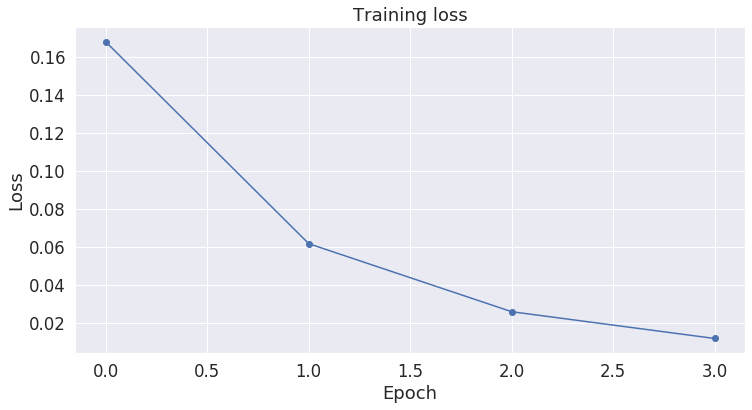

In [0]:
# visualize training loss over all batches
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Step 7: Performance on Test set

- `sklearn` 라이브러리의 `classification_report` 함수 이용하여 **accuracy, precision, recall, f1 score** 평가 지표를 이용하여 test dataset 에 대해 성능 확인
  - dataset 의 label 이 균형적인 경우 (balanced data): **accuracy**
  - dataset 의 label 이 불균형적인 경우 (imbalanced data): **f1 score**

### Step 7-1: Load Amazon Review Test Dataset


In [0]:
# pickle 모듈로 파일 load
with open(test_data, 'rb') as f:
    test_data = pc.load(f)
with open(test_label, 'rb') as f:
    test_label = pc.load(f)

print("Size of test data: {}".format(len(test_data)))
print("Size of test label: {}".format(len(test_label)))

Size of test data: 174
Size of test label: 174


### Step 7-2: Tokenization & Input Formatting

본 단계에서는 fine-tuning layer 까지 학습한 BERT 모델의 입력 format 에 맞게 amazon review test dataset 을 변환해줍니다. (*위에서 진행한 방법과 동일*)

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in test_data:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAXLEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# For every sentence
for sent in input_ids:
    # Create the attention mask.
    #  - If a token ID is 0, then it's padding, set the mask to 0.
    #  - If a token ID is not 0 ( > 0), then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_label)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Step 7-3: Evaluate on Test Set

- `.detach()`: tensor 가 기록을 추적하는 것을 중단하게 해주는 함수

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(np.argmax(logits, axis=1).flatten())
  true_labels.extend(label_ids.flatten())


print('DONE.')

Predicting labels for 174 test sentences...
DONE.


In [0]:
# accuracy, precision, recall, f1 score 성능 확인
from sklearn.metrics import classification_report
    
target_names = ['negative', 'positive']

print(classification_report(true_labels, predictions, digits=4, target_names=target_names))

              precision    recall  f1-score   support

    negative     0.9559    0.7471    0.8387        87
    positive     0.7925    0.9655    0.8705        87

    accuracy                         0.8563       174
   macro avg     0.8742    0.8563    0.8546       174
weighted avg     0.8742    0.8563    0.8546       174



## Appendix

**Timeline for some major NLP projects before BERT**

<center><img src="https://github.com/passing2961/KEMC/blob/master/before_bert.png?raw=true" width="100%" height="100%" title="beforeBERT" alt="beforeBERT"></img></center>

**Timeline for projects after BERT**

<center><img src="https://github.com/passing2961/KEMC/blob/master/after_bert.png?raw=true" width="100%" height="100%" title="afterBERT" alt="afterBERT"></img></center>

**GLUE benchmark leaderboard**
(*2020.02.04 기준*)

<center><img src="https://github.com/passing2961/KEMC/blob/master/current_glue.png?raw=true" width="100%" height="100%" title="currentGLUE" alt="currentGLUE"></img></center>


**SuperGLUE benchmark leaderboard**
(*2020.02.04 기준*)

<center><img src="https://github.com/passing2961/KEMC/blob/master/superglue.png?raw=true" width="100%" height="100%" title="SuperGLUE" alt="SuperGLUE"></img></center>



*이미지 출처: https://towardsdatascience.com/2019-year-of-bert-and-transformer-f200b53d05b9*


**Paper related with BERT**

- Transformer-XL: https://arxiv.org/abs/1901.02860
- GPT-2: https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
- ERNIE: https://arxiv.org/abs/1905.07129
- XLNet: https://arxiv.org/abs/1906.08237
- RoBERTa: https://arxiv.org/abs/1907.11692
- CTRL: https://arxiv.org/abs/1909.05858
- ALBERT: https://arxiv.org/abs/1909.11942